In [5]:
# Importing the
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)

In [6]:
# LOAD DATA & PREPROCESSING SETUP
# ----------------------------------------------------------------------------
df = pd.read_csv("Final Data.csv")

print(f"Initial data shape: {df.shape}")
print("\nData types and info:")
print(df.info())

# Clean strings and drop irrelevant columns
df.columns = [c.strip() for c in df.columns]
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()
df.drop(columns=[c for c in ["movie_imdb_link", "plot_keywords"] if c in df.columns], errors='ignore', inplace=True)

if "Release Date" in df.columns:
    df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
    df["release_year"] = df["Release Date"].dt.year
    df["release_month"] = df["Release Date"].dt.month

df.drop_duplicates(inplace=True)
if "budget" in df.columns and "gross" in df.columns:
    df.dropna(subset=["budget", "gross"], inplace=True)

# calculate ROI and success label (only if columns exist)
if "budget" in df.columns and "gross" in df.columns:
    df["ROI"] = (df["gross"] - df["budget"]) / df["budget"]

if "ROI" in df.columns and "imdb_score" in df.columns:
    df["success"] = ((df["ROI"] > 0.30) & (df["imdb_score"] > 4.5)).astype(int)

print(f"\nData after cleaning and feature engineering: {df.shape}")
print(f"Success distribution and percentage:")
print(df['success'].value_counts())
print(df['success'].value_counts(normalize=True).mul(100).round(2))

Initial data shape: (5043, 29)

Data types and info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  Release Date               5030 non-null   object 


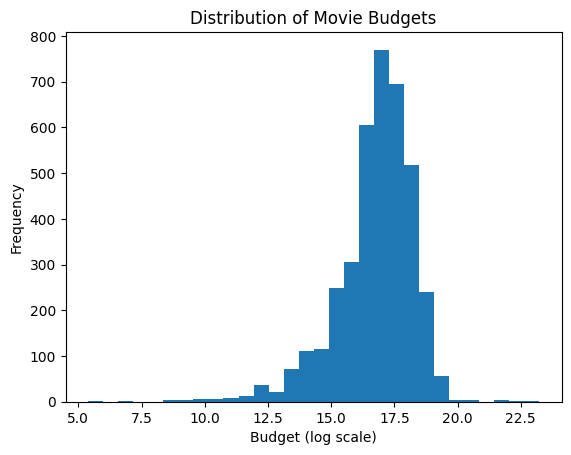

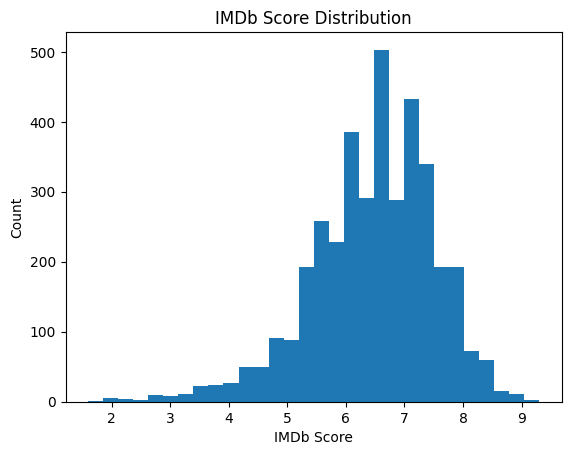

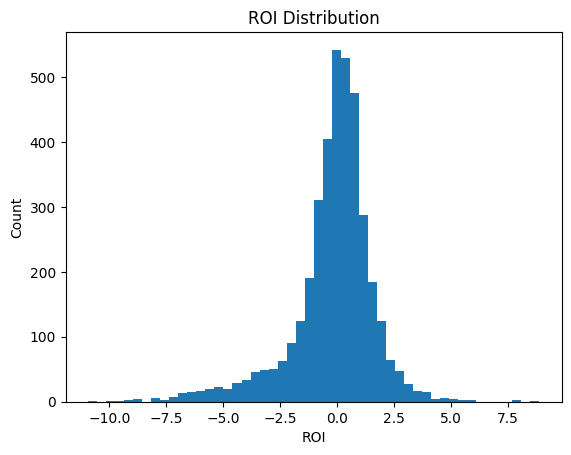

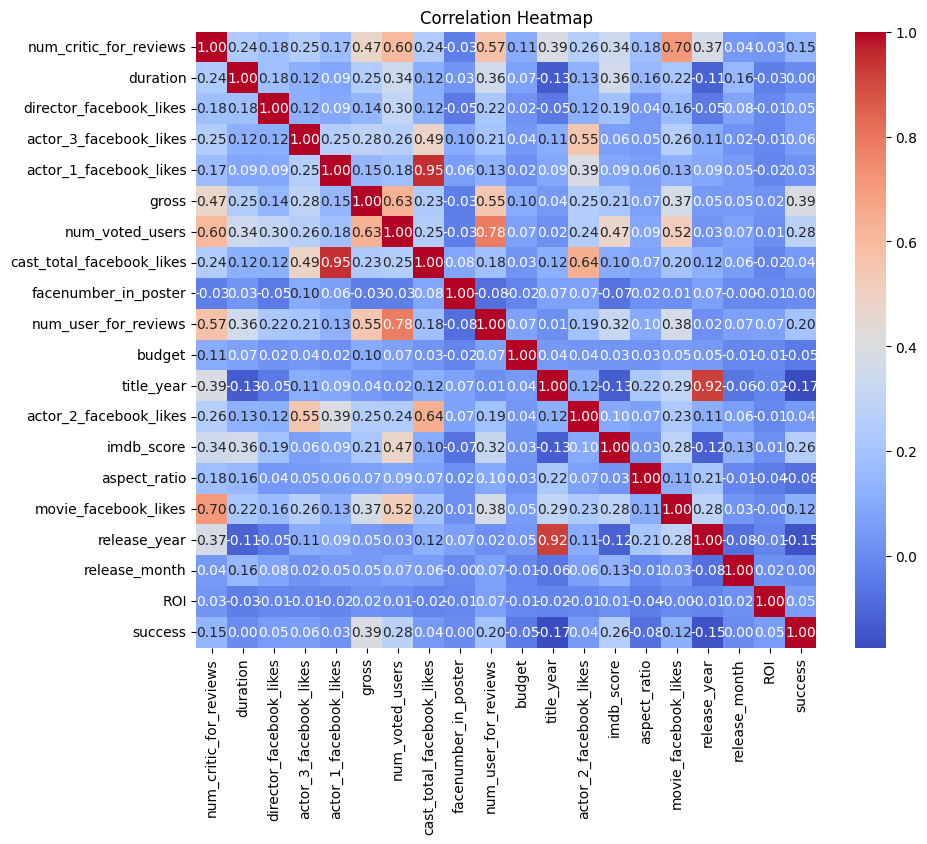

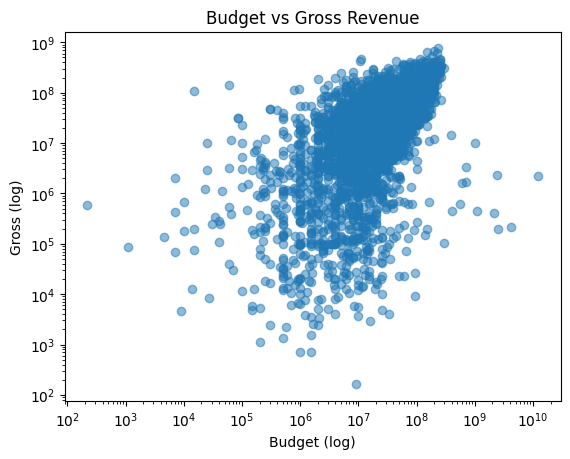

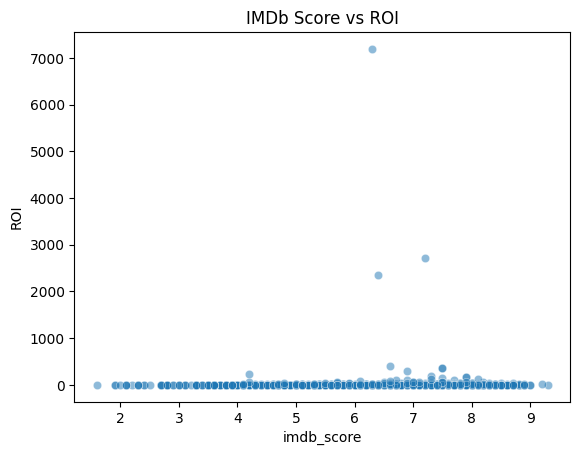

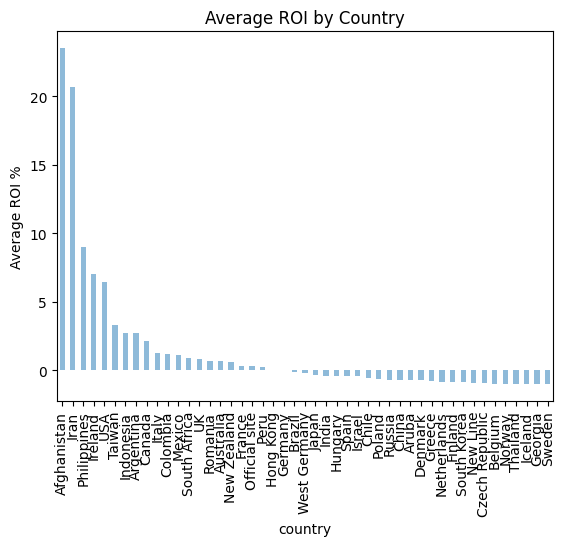

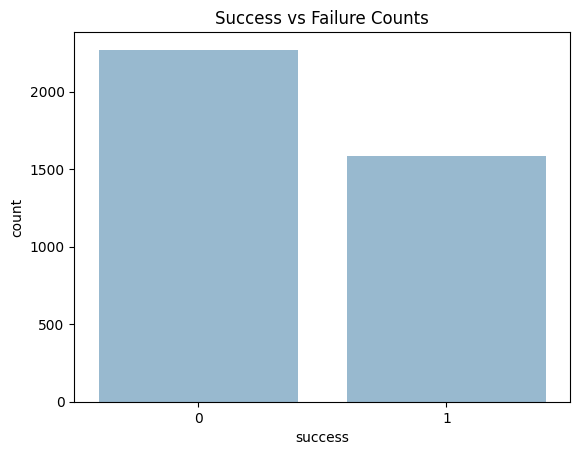


Top genres by success rate:
          Genre  Success Rate  Count
18        Short      0.500000      2
12       Horror      0.498721    391
8        Family      0.481153    451
13        Music      0.452830    159
2     Animation      0.442211    199
4        Comedy      0.441489   1504
16      Romance      0.437500    880
14      Musical      0.427184    103
19        Sport      0.423841    151
9       Fantasy      0.418288    514
6   Documentary      0.417910     67
15      Mystery      0.416667    384
1     Adventure      0.393901    787
7         Drama      0.383745   1944
3     Biography      0.382716    243
20     Thriller      0.372093   1118
17       Sci-Fi      0.366197    497
5         Crime      0.362238    715
0        Action      0.343035    962
22      Western      0.316667     60


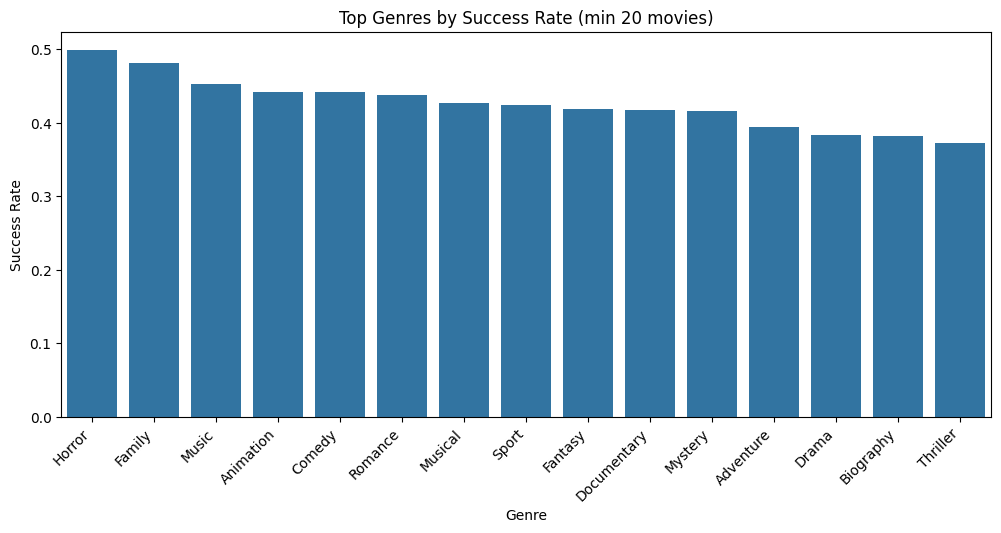

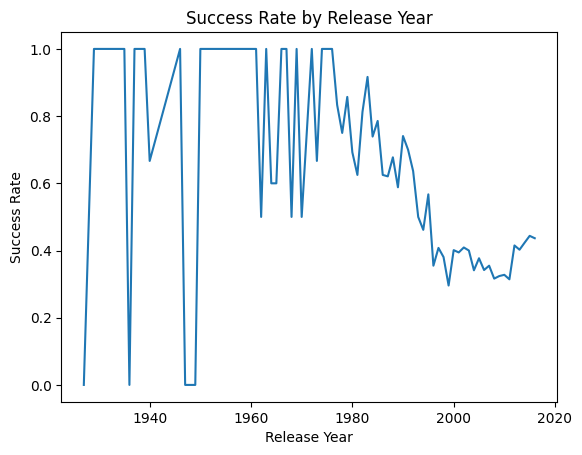


Top 10 Movies by ROI
                       movie_title          ROI  imdb_score    budget
4793           Paranormal Activity  7193.485533         6.3   15000.0
4799                     Tarnation  2714.660550         7.2     218.0
4707       The Blair Witch Project  2341.168567         6.4   60000.0
4984         The Brothers McMullen   408.864000         6.6   25000.0
3278  The Texas Chain Saw Massacre   368.427285         7.5   83532.0
4936  The Texas Chain Saw Massacre   368.427285         7.5   83532.0
5035                   El Mariachi   290.560000         6.9    7000.0
4956                   The Gallows   226.578190         4.2  100000.0
4977                 Super Size Me   176.374892         7.3   65000.0
4821                     Halloween   155.666667         7.9  300000.0

Top 10 Movies by Gross
                                    movie_title        gross  imdb_score       budget
0                                        Avatar  760505847.0         7.9  237000000.0
26          

In [7]:
# EDA VISUALIZATIONS
# ----------------------------------------------------------------------------
plt.hist(np.log1p(df["budget"]), bins=30)
plt.title("Distribution of Movie Budgets")
plt.xlabel("Budget (log scale)")
plt.ylabel("Frequency")
plt.show()

plt.hist(df["imdb_score"], bins=30)
plt.title("IMDb Score Distribution")
plt.xlabel("IMDb Score")
plt.ylabel("Count")
plt.show()

plt.hist(np.log1p(df["ROI"]), bins=50)
plt.title("ROI Distribution")
plt.xlabel("ROI")
plt.ylabel("Count")
plt.show()

num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

plt.scatter(df["budget"], df["gross"], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Budget (log)")
plt.ylabel("Gross (log)")
plt.title("Budget vs Gross Revenue")
plt.show()

sns.scatterplot(x='imdb_score', y='ROI', data=df, alpha=0.5)
plt.title("IMDb Score vs ROI")
plt.show()

country_roi = df.groupby('country')['ROI'].mean().sort_values(ascending=False)
country_roi.plot(kind='bar', alpha=0.5)
plt.title("Average ROI by Country")
plt.ylabel("Average ROI %")
plt.show()

sns.countplot(x='success', data=df, alpha=0.5)
plt.title("Success vs Failure Counts")
plt.show()

if "genres" in df.columns:
    df["genres"] = df["genres"].fillna("").astype(str)
    df["_genres_list"] = df["genres"].apply(lambda x: [g.strip() for g in x.split("|") if g.strip()])
    all_genres = sorted(set(g for lst in df["_genres_list"] for g in lst))
    genre_success = [(g, df[df["_genres_list"].apply(lambda L: g in L)]["success"].mean(), len(df[df["_genres_list"].apply(lambda L: g in L)])) for g in all_genres]
    genre_df = pd.DataFrame(genre_success, columns=["Genre", "Success Rate", "Count"]).sort_values("Success Rate", ascending=False)
    print("\nTop genres by success rate:")
    print(genre_df.head(20))
    genre_df_filtered = genre_df[genre_df["Count"]>=20].head(15)
    plt.figure(figsize=(12,5))
    sns.barplot(x="Genre", y="Success Rate", data=genre_df_filtered)
    plt.xticks(rotation=45, ha='right')
    plt.title("Top Genres by Success Rate (min 20 movies)")
    plt.show()

if "release_year" in df.columns:
    yearly_success = df.groupby("release_year")["success"].mean()
    plt.plot(yearly_success.index, yearly_success.values)
    plt.title("Success Rate by Release Year")
    plt.xlabel("Release Year")
    plt.ylabel("Success Rate")
    plt.show()

print("\nTop 10 Movies by ROI")
print(df.sort_values("ROI", ascending=False)[["movie_title", "ROI", "imdb_score", "budget"]].head(10))

print("\nTop 10 Movies by Gross")
print(df.sort_values("gross", ascending=False)[["movie_title", "gross", "imdb_score", "budget"]].head(10))

print("\nTop 10 Movies by Budget")
print(df.sort_values("budget", ascending=False)[["movie_title", "budget", "imdb_score"]].head(10))

In [8]:
# HANDLE MISSING VALUES WITH SAFEGUARDS
# ----------------------------------------------------------------------------
print("\n[Starting Missing Value Handling]")
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=["object"]).columns:
    try:
        m = df[col].mode().iloc[0]
        if isinstance(m, (str, int, float, np.integer, np.floating)):
            df[col] = df[col].fillna(m)
        else:
            df[col] = df[col].fillna('Unknown')
    except:
        df[col] = df[col].fillna('Unknown')

df.to_csv("movies_cleaned_pipeline.csv", index=False)
print("Cleaned data saved to 'movies_cleaned_pipeline.csv'")


[Starting Missing Value Handling]
Cleaned data saved to 'movies_cleaned_pipeline.csv'


In [9]:
# PREPROCESSOR CLASS
# ============================================================================
class MoviePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, include_gross=False, include_roi=False, include_imdb=False):
        self.include_gross = include_gross
        self.include_roi = include_roi
        self.include_imdb = include_imdb
        self.freq_maps = {}
        self.label_encoders = {}
        self.mlb = None
        self.scaler = None
        self.genre_columns = []
        self.feature_names = []

    def fit(self, X, y=None):
        X_copy = X.copy()
        name_cols = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
        # Build frequency maps with string keys
        for col in name_cols:
            if col in X_copy.columns:
                self.freq_maps[col] = X_copy[col].astype(str).value_counts(normalize=True)
        label_cols = ['color', 'language', 'country', 'content_rating']
        for col in label_cols:
            if col in X_copy.columns:
                le = LabelEncoder()
                le.fit(X_copy[col].astype(str))
                self.label_encoders[col] = le
        if '_genres_list' in X_copy.columns:
            X_copy["_genres_list"] = X_copy["_genres_list"].apply(
                lambda x: [i.strip() for i in x.strip("[]").replace("'", "").split(",")] if isinstance(x, str) else x
            )
            self.mlb = MultiLabelBinarizer()
            self.mlb.fit(X_copy["_genres_list"])
            self.genre_columns = list(self.mlb.classes_)
        self.scaler = StandardScaler()
        self._transform_features(X_copy, fit_scaler=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        return self._transform_features(X_copy, fit_scaler=False)

    def _transform_features(self, X_copy, fit_scaler=False):
        # Frequency encode name columns; use string matching for mapping safety
        name_cols = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
        for col in name_cols:
            if col in X_copy.columns:
                X_copy[col + '_freq'] = X_copy[col].astype(str).map(self.freq_maps[col]).fillna(0)
        X_copy.drop(columns=[col for col in name_cols if col in X_copy.columns], inplace=True, errors='ignore')

        # Label encode
        label_cols = ['color', 'language', 'country', 'content_rating']
        for col in label_cols:
            if col in X_copy.columns:
                le = self.label_encoders.get(col)
                X_copy[col] = X_copy[col].astype(str).apply(
                    lambda x: le.transform([x])[0] if le and x in le.classes_ else -1
                )

        # Multilabel binarize genres
        if '_genres_list' in X_copy.columns and self.mlb is not None:
            X_copy["_genres_list"] = X_copy["_genres_list"].apply(
                lambda x: [i.strip() for i in x.strip("[]").replace("'", "").replace('"', '').split(",")] 
                if isinstance(x, str) else x
            )
            genre_encoded = pd.DataFrame(
                self.mlb.transform(X_copy["_genres_list"]),
                columns=self.mlb.classes_,
                index=X_copy.index
            )
            X_copy = pd.concat([X_copy, genre_encoded], axis=1)
            X_copy.drop(columns=['_genres_list'], inplace=True)

        # Drop unwanted columns
        drop_cols = ['genres', 'movie_title', 'Release Date', 'title_year', 'release_year']
        X_copy.drop(columns=[col for col in drop_cols if col in X_copy.columns], inplace=True)

        # Log transform selected columns safely
        log_cols = ['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                    'actor_3_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes',
                    'num_user_for_reviews', 'budget', 'movie_facebook_likes']
        if self.include_gross and 'gross' in X_copy.columns:
            log_cols.append('gross')
        for col in log_cols:
            if col in X_copy.columns:
                X_copy[col] = np.log1p(X_copy[col].fillna(0))
        # Drop ROI, gross, imdb_score as needed
        if not self.include_roi and 'ROI' in X_copy.columns:
            X_copy.drop(columns=['ROI'], inplace=True)
        if not self.include_gross and 'gross' in X_copy.columns:
            X_copy.drop(columns=['gross'], inplace=True)
        if not self.include_imdb and 'imdb_score' in X_copy.columns:
            X_copy.drop(columns=['imdb_score'], inplace=True)
        # Scale
        numeric_cols = X_copy.select_dtypes(include=[np.number]).columns
        if fit_scaler:
            X_copy[numeric_cols] = self.scaler.fit_transform(X_copy[numeric_cols])
        else:
            X_copy[numeric_cols] = self.scaler.transform(X_copy[numeric_cols])
        self.feature_names = X_copy.columns.tolist()
        return X_copy

In [10]:
# SPLIT DATA FOR MODELING
# ======================================================================
pre_release_features = [
    'color', 'director_name', 'num_critic_for_reviews', 'duration',
    'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
    'actor_1_facebook_likes', 'genres', 'actor_1_name', 'num_voted_users',
    'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
    'num_user_for_reviews', 'language', 'country', 'content_rating',
    'budget', 'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
    'release_month', '_genres_list'
]
pre_release_features = [col for col in pre_release_features if col in df.columns]

X = df[pre_release_features].copy()
y_gross = df['gross'].copy()
y_success = df['success'].copy()

X_train, X_test, y_gross_train, y_gross_test, y_success_train, y_success_test = \
    train_test_split(X, y_gross, y_success, test_size=0.2, stratify=y_success, random_state=42)

In [11]:
# GROSS PREDICTION TRAINING - MULTIPLE MODELS
# ======================================================================
gross_preprocessor = MoviePreprocessor(include_gross=False, include_roi=False, include_imdb=False)
X_train_gross = gross_preprocessor.fit_transform(X_train)
X_test_gross = gross_preprocessor.transform(X_test)

y_gross_train_log = np.log1p(y_gross_train)
y_gross_test_log = np.log1p(y_gross_test)

linreg = LinearRegression()
linreg.fit(X_train_gross, y_gross_train_log)
lin_rmse = np.sqrt(mean_squared_error(np.expm1(y_gross_test_log), np.expm1(linreg.predict(X_test_gross))))

ridge = Ridge()
ridge_grid = GridSearchCV(ridge, {'alpha': [0.1, 1, 10]}, scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train_gross, y_gross_train_log)
ridge_rmse = np.sqrt(mean_squared_error(np.expm1(y_gross_test_log), np.expm1(ridge_grid.predict(X_test_gross))))

lasso = Lasso()
lasso_grid = GridSearchCV(lasso, {'alpha': [0.01, 0.1, 1]}, scoring='neg_root_mean_squared_error')
lasso_grid.fit(X_train_gross, y_gross_train_log)
lasso_rmse = np.sqrt(mean_squared_error(np.expm1(y_gross_test_log), np.expm1(lasso_grid.predict(X_test_gross))))

rf_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, None], 'min_samples_split': [2, 5]}
rf_reg = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, n_iter=5, scoring='neg_root_mean_squared_error')
rf_reg.fit(X_train_gross, y_gross_train_log)
rf_rmse = np.sqrt(mean_squared_error(np.expm1(y_gross_test_log), np.expm1(rf_reg.predict(X_test_gross))))

xgb_params = {'n_estimators': [200, 400], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
xgb_reg = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'), xgb_params, cv=2, scoring='neg_root_mean_squared_error')
xgb_reg.fit(X_train_gross, y_gross_train_log)
xgb_rmse = np.sqrt(mean_squared_error(np.expm1(y_gross_test_log), np.expm1(xgb_reg.predict(X_test_gross))))

print("\nRegression validation RMSEs:")
print(f"LinearRegression: {lin_rmse:.2f}")
print(f"Ridge: {ridge_rmse:.2f}")
print(f"Lasso: {lasso_rmse:.2f}")
print(f"RandomForest: {rf_rmse:.2f}")
print(f"XGBoost: {xgb_rmse:.2f}")

reg_dict = {
    'Linear': (linreg, lin_rmse),
    'Ridge': (ridge_grid.best_estimator_, ridge_rmse),
    'Lasso': (lasso_grid.best_estimator_, lasso_rmse),
    'RandomForest': (rf_reg.best_estimator_, rf_rmse),
    'XGBoost': (xgb_reg.best_estimator_, xgb_rmse)
}

best_reg_name, (gross_model, best_reg_rmse) = min(reg_dict.items(), key=lambda t:t[1][1])
print(f"\nSelected best GROSS model: {best_reg_name} with RMSE={best_reg_rmse:.2f}")


Regression validation RMSEs:
LinearRegression: 60493761.94
Ridge: 59060978.18
Lasso: 53787173.68
RandomForest: 31914234.67
XGBoost: 33879987.53

Selected best GROSS model: RandomForest with RMSE=31914234.67


In [12]:
# SUCCESS PREDICTION TRAINING - MULTIPLE MODELS WITH SMOTE AND AUC
# ======================================================================
X_train_gross_pred = gross_preprocessor.transform(X_train)
y_gross_train_pred_log = gross_model.predict(X_train_gross_pred)
y_gross_train_pred = np.expm1(y_gross_train_pred_log)

X_test_gross_pred = gross_preprocessor.transform(X_test)
y_gross_test_pred_log = gross_model.predict(X_test_gross_pred)
y_gross_test_pred = np.expm1(y_gross_test_pred_log)

X_train_with_gross = X_train.copy()
X_train_with_gross['gross'] = y_gross_train_pred
X_train_with_gross['ROI'] = (y_gross_train_pred - X_train['budget']) / X_train['budget']

X_test_with_gross = X_test.copy()
X_test_with_gross['gross'] = y_gross_test_pred
X_test_with_gross['ROI'] = (y_gross_test_pred - X_test['budget']) / X_test['budget']

success_preprocessor = MoviePreprocessor(include_gross=True, include_roi=True, include_imdb=False)

X_train_success = success_preprocessor.fit_transform(X_train_with_gross)
X_test_success = success_preprocessor.transform(X_test_with_gross)

USE_SMOTE = True
if USE_SMOTE:
    sm = SMOTE(random_state=42)
    X_train_bal, y_success_train_bal = sm.fit_resample(X_train_success, y_success_train)
    print(f"SMOTE is enabled. Training size after resampling: {len(X_train_bal)}")
else:
    X_train_bal, y_success_train_bal = X_train_success, y_success_train
    print(f"SMOTE is disabled. Using original training size: {len(X_train_bal)}")

clf_results = {}

logreg_params = {'C': [0.1, 0.5, 1, 5]}
logreg = GridSearchCV(LogisticRegression(max_iter=200), logreg_params, scoring='roc_auc')
logreg.fit(X_train_bal, y_success_train_bal)
logreg_y_pred = logreg.predict(X_test_success)
logreg_y_proba = logreg.predict_proba(X_test_success)[:, 1]
clf_results['Logistic'] = (
    logreg.best_estimator_,
    accuracy_score(y_success_test, logreg_y_pred),
    roc_auc_score(y_success_test, logreg_y_proba)
)

ridge_clf_params = {'alpha': [0.1, 1, 10]}
ridgeclf = GridSearchCV(RidgeClassifier(), ridge_clf_params, scoring='accuracy')
ridgeclf.fit(X_train_bal, y_success_train_bal)
ridge_y_pred = ridgeclf.predict(X_test_success)
ridge_auc = roc_auc_score(y_success_test, ridge_y_pred)
clf_results['RidgeClassifier'] = (
    ridgeclf.best_estimator_,
    accuracy_score(y_success_test, ridge_y_pred),
    ridge_auc
)

rf_clf_params = {'n_estimators': [200, 400], 'max_depth': [3, 6, None], 'min_samples_split': [2, 4, 8]}
rf_clf = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_clf_params, n_iter=6, scoring='roc_auc')
rf_clf.fit(X_train_bal, y_success_train_bal)
rf_y_pred = rf_clf.predict(X_test_success)
rf_y_proba = rf_clf.predict_proba(X_test_success)[:, 1]
clf_results['RandomForest'] = (
    rf_clf.best_estimator_,
    accuracy_score(y_success_test, rf_y_pred),
    roc_auc_score(y_success_test, rf_y_proba)
)

xgb_clf_params = {'n_estimators': [200, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
xgb_clf = GridSearchCV(XGBClassifier(random_state=42), xgb_clf_params, cv=2, scoring='roc_auc')
xgb_clf.fit(X_train_bal, y_success_train_bal)
xgb_y_pred = xgb_clf.predict(X_test_success)
xgb_y_proba = xgb_clf.predict_proba(X_test_success)[:, 1]
clf_results['XGBoost'] = (
    xgb_clf.best_estimator_,
    accuracy_score(y_success_test, xgb_y_pred),
    roc_auc_score(y_success_test, xgb_y_proba)
)

print("\nClassification validation accuracies and AUCs:")
for model_name, (model, acc, auc) in clf_results.items():
    print(f"{model_name:15}: Accuracy={acc:.4f}, AUC={auc:.4f}")

best_clf_name, (success_model, best_clf_acc, best_clf_auc) = max(clf_results.items(), key=lambda x: x[1][2])
print(f"\nSelected best SUCCESS classifier: {best_clf_name} (Accuracy={best_clf_acc:.4f}, AUC={best_clf_auc:.4f})")

SMOTE is enabled. Training size after resampling: 3632

Classification validation accuracies and AUCs:
Logistic       : Accuracy=0.7370, AUC=0.8004
RidgeClassifier: Accuracy=0.7306, AUC=0.7290
RandomForest   : Accuracy=0.7604, AUC=0.8212
XGBoost        : Accuracy=0.7526, AUC=0.7957

Selected best SUCCESS classifier: RandomForest (Accuracy=0.7604, AUC=0.8212)


In [12]:
# PIPELINE OBJECT WITH PREDICTOR, SAVING MODELS AND COMPONENTS
# ============================================================================
class TwoStageMoviePipeline(BaseEstimator, ClassifierMixin):
    def __init__(self, gross_model=None, success_model=None, gross_preprocessor=None, success_preprocessor=None):
        self.gross_model = gross_model
        self.success_model = success_model
        self.gross_preprocessor = gross_preprocessor
        self.success_preprocessor = success_preprocessor
    def fit(self, X, y=None): return self
    def predict(self, X):
        X_gross_processed = self.gross_preprocessor.transform(X.copy())
        predicted_gross = np.expm1(self.gross_model.predict(X_gross_processed))
        X_success_input = X.copy()
        X_success_input['gross'] = predicted_gross
        X_success_input['ROI'] = (predicted_gross - X_success_input['budget']) / X_success_input['budget']
        X_success_processed = self.success_preprocessor.transform(X_success_input)
        predicted_success = self.success_model.predict(X_success_processed)
        predicted_proba = self.success_model.predict_proba(X_success_processed)[:, 1]
        return {
            'predicted_gross': predicted_gross,
            'predicted_success': predicted_success,
            'success_probability': predicted_proba
        }
            
    def predict_proba(self, X):
        X_gross_processed = self.gross_preprocessor.transform(X.copy())
        predicted_gross = self.gross_model.predict(X_gross_processed)
        predicted_gross = np.expm1(predicted_gross)
        X_success_input = X.copy()
        X_success_processed = self.success_preprocessor.transform(X_success_input)
        predicted_proba = self.success_model.predict_proba(X_success_processed)
        return predicted_proba
    # def predict_with_gross(self, X):
    #     X_gross_processed = self.gross_preprocessor.transform(X.copy())
    #     predicted_gross = self.gross_model.predict(X_gross_processed)
    #     predicted_gross = np.expm1(predicted_gross)
    #     X_success_input = X.copy()
    #     X_success_processed = self.success_preprocessor.transform(X_success_input)
    #     predicted_success = self.success_model.predict(X_success_processed)
    #     predicted_proba = self.success_model.predict_proba(X_success_processed)[:, 1]
    #     return {'predicted_gross': predicted_gross, 'predicted_success': predicted_success, 'success_probability': predicted_proba}
    def predict_with_gross(self, X):
        X_gross_processed = self.gross_preprocessor.transform(X.copy())
        predicted_gross = np.expm1(self.gross_model.predict(X_gross_processed))
        X_success_input = X.copy()
        X_success_input['gross'] = predicted_gross
        X_success_input['ROI'] = (predicted_gross - X_success_input['budget']) / X_success_input['budget']
        X_success_processed = self.success_preprocessor.transform(X_success_input)
        predicted_success = self.success_model.predict(X_success_processed)
        predicted_proba = self.success_model.predict_proba(X_success_processed)[:, 1]
        return {
            'predicted_gross': predicted_gross,
            'predicted_success': predicted_success,
            'success_probability': predicted_proba
        }

full_pipeline = TwoStageMoviePipeline(
    gross_model=gross_model,
    success_model=success_model,
    gross_preprocessor=gross_preprocessor,
    success_preprocessor=success_preprocessor
)
joblib.dump(full_pipeline, 'movie_success_pipeline_complete.pkl')
print("\n✓ Saved complete pipeline as 'movie_success_pipeline_complete.pkl'")

pipeline_components = {
    'gross_model': gross_model,
    'success_model': success_model,
    'gross_preprocessor': gross_preprocessor,
    'success_preprocessor': success_preprocessor,
    'pre_release_features': pre_release_features,
    'metrics': {
        'gross_rmse': best_reg_rmse,
        'success_accuracy': best_clf_acc,
        'success_auc': best_clf_auc
    }
}
joblib.dump(pipeline_components, 'pipeline_components.pkl')
print("✓ Saved pipeline components as 'pipeline_components.pkl'")

def predict_movie_success(movie_data_dict):
    pipeline = joblib.load('movie_success_pipeline_complete.pkl')
    movie_df = pd.DataFrame([movie_data_dict])
    predictions = pipeline.predict_with_gross(movie_df)
    return {
        'success_prediction': 'Success ✓' if predictions['predicted_success'][0] == 1 else 'Failure ✗',
        'success_probability': f"{predictions['success_probability'][0]:.2%}",
        'predicted_gross': f"${predictions['predicted_gross'][0]:,.2f}",
        'recommendation': 'GREENLIGHT' if predictions['success_probability'][0] > 0.6 else 'REVIEW' if predictions['success_probability'][0] > 0.4 else 'REJECT'
    }

joblib.dump(predict_movie_success, 'predict_function.pkl')

print("\nPIPELINE BUILD COMPLETE!")
print("You can now predict on unseen data using the pipeline.")


✓ Saved complete pipeline as 'movie_success_pipeline_complete.pkl'
✓ Saved pipeline components as 'pipeline_components.pkl'

PIPELINE BUILD COMPLETE!
You can now predict on unseen data using the pipeline.


In [ ]:
# import pandas as pd
# import joblib

# # Load your pipeline
# pipeline = joblib.load('movie_success_pipeline_complete.pkl')

# # Define the list of required features
# feature_list = [
#     'color', 'director_name', 'num_critic_for_reviews', 'duration',
#     'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
#     'actor_1_facebook_likes', 'genres', 'actor_1_name', 'num_voted_users',
#     'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
#     'num_user_for_reviews', 'language', 'country', 'content_rating',
#     'budget', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
#     'movie_facebook_likes', 'release_month'
# ]

# # Collect user input
# movie_data = {}

# print("Please enter the data for the new movie:")

# for feature in feature_list:
#     val = input(f"{feature}: ")
#     if feature in [
#         'num_critic_for_reviews', 'duration', 'director_facebook_likes', 
#         'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', 
#         'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 
#         'budget', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio', 
#         'movie_facebook_likes', 'release_month'
#     ]:
#         try:
#             if '.' in val:
#                 val = float(val)
#             else:
#                 val = int(val)
#         except:
#             pass
#     movie_data[feature] = val

# # Handle genres field to expected string format
# if 'genres' in movie_data:
#     genres_list = [g.strip() for g in movie_data['genres'].split('|') if g.strip()]
#     movie_data['_genres_list'] = str(genres_list)
# else:
#     movie_data['_genres_list'] = '[]'

# # Create DataFrame for prediction
# movie_df = pd.DataFrame([movie_data])

# # Use the pipeline's predict method that internally adds gross and ROI
# results = pipeline.predict(movie_df)

# # Access predictions properly from dictionary with 0-index for array
# success_pred = results['predicted_success'][0]
# success_proba = results['success_probability'][0]
# predicted_gross = results['predicted_gross'][0]

# print("\nPrediction Results:")
# print(f"Success Prediction: {'SUCCESS ✓' if success_pred == 1 else 'FAILURE ✗'}")
# print(f"Success Probability: {success_proba:.2%}")
# print(f"Predicted Gross: ${predicted_gross:,.2f}")

In [13]:
import pandas as pd
import joblib

# Load your two-stage pipeline (trained without IMDb score as feature)
pipeline = joblib.load('movie_success_pipeline_complete.pkl')

# Define features to collect (IMDb excluded as not available pre-release)
feature_list = [
    'color', 'director_name', 'num_critic_for_reviews', 'duration',
    'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
    'actor_1_facebook_likes', 'genres', 'actor_1_name', 'num_voted_users',
    'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
    'num_user_for_reviews', 'language', 'country', 'content_rating',
    'budget', 'actor_2_facebook_likes', 'aspect_ratio',
    'movie_facebook_likes', 'release_month'
]

movie_data_list = []
num_movies = int(input("How many new movies do you want to enter? "))

for i in range(num_movies):
    print(f"\nEnter details for movie #{i+1}")
    movie_data = {}
    for feature in feature_list:
        val = input(f"{feature}: ").strip()
        # Convert numeric fields
        if feature in ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
                       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
                       'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews',
                       'budget', 'actor_2_facebook_likes', 'aspect_ratio',
                       'movie_facebook_likes', 'release_month']:
            try:
                val = float(val) if '.' in val else int(val)
            except Exception:
                pass
        movie_data[feature] = val

    # Convert genres pipe-separated string into a list representation string for pipeline
    if 'genres' in movie_data:
        genres_list = [g.strip() for g in movie_data['genres'].split('|') if g.strip()]
        movie_data['_genres_list'] = str(genres_list)
    else:
        movie_data['_genres_list'] = '[]'

    movie_data_list.append(movie_data)

# Create DataFrame with multiple rows
movies_df = pd.DataFrame(movie_data_list)

# Predict for all entered movies
predictions = pipeline.predict(movies_df)

for idx in range(num_movies):
    print(f"\nMovie #{idx+1} prediction:")
    success_pred = predictions['predicted_success'][idx]
    success_prob = predictions['success_probability'][idx]
    gross_pred = predictions['predicted_gross'][idx]
    print(f"Success Prediction: {'SUCCESS ✓' if success_pred == 1 else 'FAILURE ✗'}")
    print(f"Success Probability: {success_prob:.2%}")
    print(f"Predicted Gross: ${gross_pred:,.2f}")

How many new movies do you want to enter?  2



Enter details for movie #1


color:  Color
director_name:  Christopher Nolan
num_critic_for_reviews:  723
duration:  169
director_facebook_likes:  0
actor_3_facebook_likes:  23000
actor_2_name:  Christian Bale
actor_1_facebook_likes:  40000
genres:  Action|Sci-Fi|Thriller
actor_1_name:  Matthew McConaughey
num_voted_users:  1047747
cast_total_facebook_likes:  63000
actor_3_name:  Anne Hathaway
facenumber_in_poster:  0
num_user_for_reviews:  2075
language:  English
country:  USA
content_rating:  PG-13
budget:  165000000
actor_2_facebook_likes:  0
aspect_ratio:  2.35
movie_facebook_likes:  164000
release_month:  11



Enter details for movie #2


color:  Color
director_name:  Mel Gibson
num_critic_for_reviews:  543
duration:  201
director_facebook_likes:  1200
actor_3_facebook_likes:  23000
actor_2_name:  Jim Caviezel
actor_1_facebook_likes:  4500
genres:  Action|Thriller
actor_1_name:  Monica Belluci
num_voted_users:  3455
cast_total_facebook_likes:  34550
actor_3_name:  Mark Ruffalo
facenumber_in_poster:  0
num_user_for_reviews:  243
language:  English
country:  USA
content_rating:  PG-13
budget:  25000000
actor_2_facebook_likes:  3400
aspect_ratio:  2.19
movie_facebook_likes:  12363
release_month:  3



Movie #1 prediction:
Success Prediction: SUCCESS ✓
Success Probability: 81.96%
Predicted Gross: $309,731,238.65

Movie #2 prediction:
Success Prediction: FAILURE ✗
Success Probability: 15.39%
Predicted Gross: $3,606,276.28


In [14]:
import subprocess

def generate_requirements_txt(output_path='requirements.txt'):
    result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)
    with open(output_path, 'w') as f:
        f.write(result.stdout)
    print(f"Requirements saved to {output_path}")

generate_requirements_txt()

Requirements saved to requirements.txt
